In [2]:
import glob
import os
import shutil
import time

from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import train_config
from criterions.my_loss import SpatialEmbLoss
from datasets import get_dataset
from models import get_model
from utils.utils import AverageMeter, Cluster, Logger, Visualizer

args = train_config.get_args()
device = torch.device("cuda:0" if args['cuda'] else "cpu")

In [3]:
# train dataloader
train_dataset = get_dataset(
    args['train_dataset']['name'], args['train_dataset']['kwargs'])
train_dataset_it = torch.utils.data.DataLoader(
    train_dataset, batch_size=args['train_dataset']['batch_size'], shuffle=False, drop_last=True, num_workers=0, pin_memory=True if args['cuda'] else False)

Cityscapes Dataset created


In [4]:
for i, sample in enumerate(train_dataset_it):

    im = sample['image']
    instances = sample['instance'].squeeze()
    class_labels = sample['label'].squeeze()
    
    if i == 0:
        break
        
print('image :', sample['image'].shape, type(sample['image']))
print('instance :', sample['instance'].shape, type(sample['instance']))
print('label :', sample['label'].shape, type(sample['label']))

image : torch.Size([16, 3, 512, 512]) <class 'torch.Tensor'>
instance : torch.Size([16, 1, 512, 512]) <class 'torch.Tensor'>
label : torch.Size([16, 1, 512, 512]) <class 'torch.Tensor'>


## Input, Instance-GT, Semantic-GT

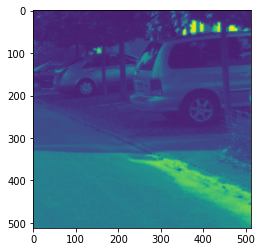

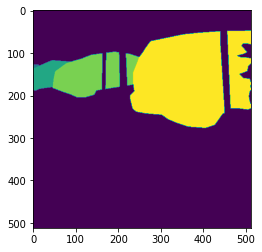

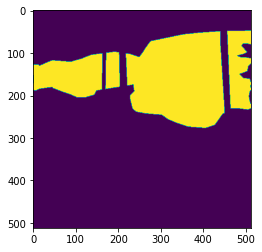

In [5]:
import matplotlib.pyplot as plt

i = 0

plt.imshow(im[i][2].numpy())
plt.show()
plt.imshow(instances[i].numpy())
plt.show()
plt.imshow(class_labels[i].numpy())
plt.show()

## Model

In [6]:
model = get_model(args['model']['name'], args['model']['kwargs'])
model = torch.nn.DataParallel(model).to(device)

state = torch.load('C:/Users/Moon/Desktop/SpatialEmbeddings-master/pretrained_models/cars_pretrained_model.pth')
model.load_state_dict(state['model_state_dict'])
model

Creating branched erfnet with [3, 1] classes


DataParallel(
  (module): BranchedERFNet(
    (encoder): Encoder(
      (initial_block): DownsamplerBlock(
        (conv): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layers): ModuleList(
        (0): DownsamplerBlock(
          (conv): Conv2d(16, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): non_bottleneck_1d(
          (conv3x1_1): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
          (conv1x3_1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
          (bn1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=Tr

## Prediction

* 2 offset vectors

* sigma map

* seed map

torch.Size([16, 4, 512, 512])


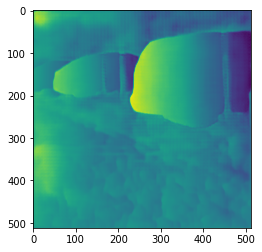

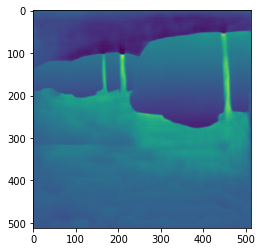

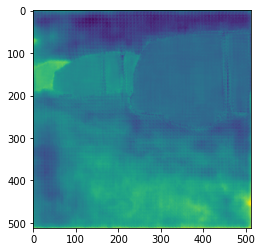

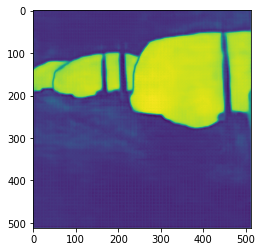

In [27]:
output = model(im)
print(output.shape)

plt.imshow(output[i][0].cpu().detach().numpy())  # offset vector x
plt.show()
plt.imshow(output[i][1].cpu().detach().numpy())  # offset vector y
plt.show()
plt.imshow(output[i][2].cpu().detach().numpy())  # sigma map
plt.show()
plt.imshow(output[i][3].cpu().detach().numpy())  # seed map
plt.show()

## Clustering & Visualization

In [28]:
cluster = Cluster()

# Visualizer
visualizer = Visualizer(('image', 'pred', 'sigma', 'seed'))

In [29]:
predictions = cluster.cluster_with_gt(output[0], instances[0], n_sigma=args['loss_opts']['n_sigma'])
print(predictions.shape)

torch.Size([512, 512])


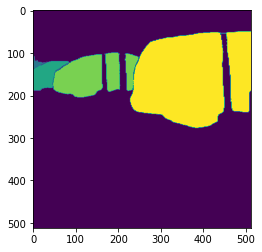

In [30]:
plt.imshow(predictions.cpu().detach().numpy())
plt.show()

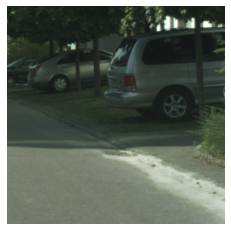

In [31]:
visualizer.display(im[0], 'image')

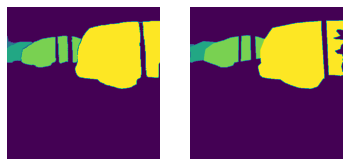

In [32]:
visualizer.display([predictions.cpu(), instances[0].cpu()], 'pred')

## Clustering in detail

In [33]:
print(output.shape)
print(instances.shape)

prediction = output[0]
instance = instances[0]

torch.Size([16, 4, 512, 512])
torch.Size([16, 512, 512])


### 1. x, y coordinate maps

In [146]:
# x, y coordinate maps
xm = torch.linspace(0, 2, 2048).view(1, 1, -1).expand(1, 1024, 2048)
ym = torch.linspace(0, 1, 1024).view(1, -1, 1).expand(1, 1024, 2048)
xym = torch.cat((xm, ym), 0)

xym = xym.cuda()

print(xym.shape)

torch.Size([2, 1024, 2048])


### 2. Calculate spatial embeddings

In [147]:
height, width = prediction.size(1), prediction.size(2)
xym_s = xym[:, 0:height, 0:width]

# spatial_emb = offset_vectors (first 2 channels of model output) + coordinate maps
n_sigma = 1
spatial_emb = torch.tanh(prediction[0:2]) + xym_s  # 2 x h x w
sigma = prediction[2:2+n_sigma]  # n_sigma x h x w
    
instance_map = torch.zeros(height, width).byte().cuda()
        
unique_instances = instance.unique()
unique_instances = unique_instances[unique_instances != 0]

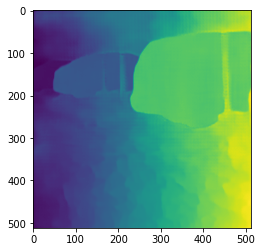

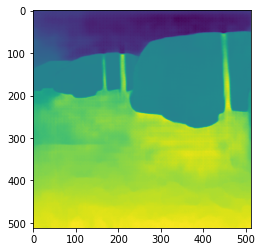

In [148]:
plt.imshow(spatial_emb[0].cpu().detach().numpy())
plt.show()
plt.imshow(spatial_emb[1].cpu().detach().numpy())
plt.show()

### 3. Post-processing & Clustering regarding to each instance

In [149]:
unique_instances  # except bg

tensor([2, 3, 4, 5], dtype=torch.uint8)

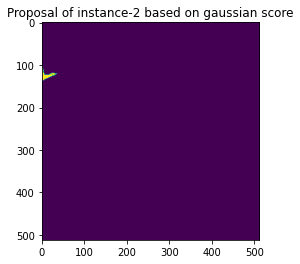

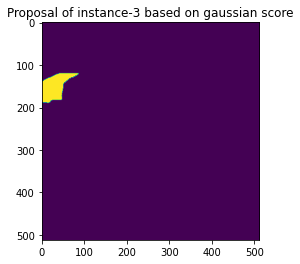

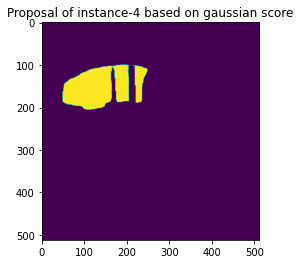

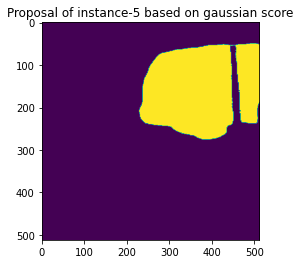

In [150]:
dists = []

for id in unique_instances:
            
    # mask of specific instance (RoI area)
    # spatial_emb, sigma below consider only pixels of RoI area
    mask = instance.eq(id).view(1, height, width)  # (1, h, w)

    # center of instance (mean embedding)
    center = spatial_emb[mask.expand_as(spatial_emb)].view(
        2, -1).mean(1).view(2, 1, 1)  # 2 x 1 x 1

    # define sigma_k - e.q (7)
    s = sigma[mask.expand_as(sigma)].view(n_sigma, -1).mean(1).view(n_sigma, 1, 1)
    s = torch.exp(s*10)  # n_sigma x 1 x 1
            
    # calculate gaussian score(distance of each pixel embedding from the center)
    # high value -> pixel embedding is close to the center
    dist = torch.exp(-1 * torch.sum(torch.pow(spatial_emb - center, 2)*s, 0))  # (h, w)
    dists.append(dist)
    
    # e.q (11)
    proposal = (dist > 0.5)  # (h, w)
    plt.imshow(proposal.cpu().detach().numpy())
    plt.title(f'Proposal of instance-{id} based on gaussian score')
    plt.show()
    instance_map[proposal] = id  # (h, w)

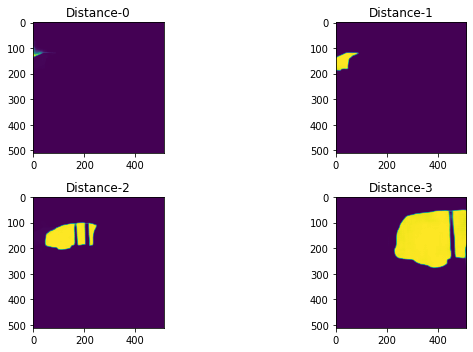

In [151]:
rows = 2
cols = 2
axes = []
fig = plt.figure(figsize=(10, 5))

for a in range(rows * cols):
    b = dists[a].cpu().detach()
    axes.append(fig.add_subplot(rows, cols, a+1) )
    subplot_title = ("Distance-" + str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
    
fig.tight_layout()    
plt.show()

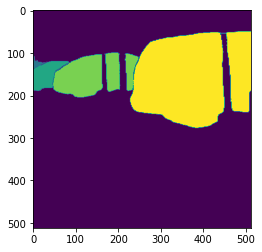

In [107]:
plt.imshow(instance_map.cpu().detach().numpy())
plt.show()

## Clustering (test)

In [126]:
cluster = Cluster()

output = model(im)
instance_map, predictions = cluster.cluster(output[0], threshold=0.9)

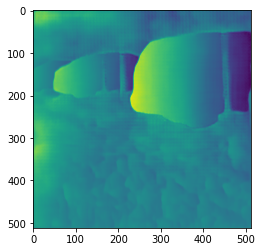

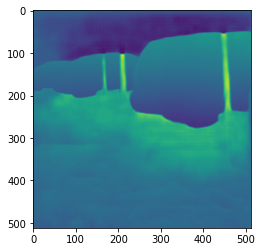

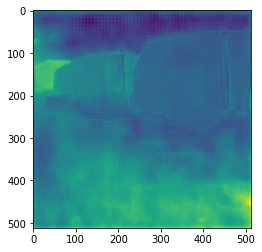

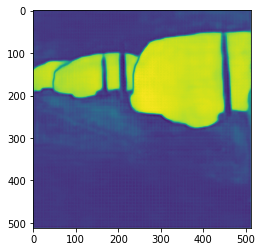

In [127]:
i = 0

plt.imshow(output[i][0].cpu().detach().numpy())
plt.show()
plt.imshow(output[i][1].cpu().detach().numpy())
plt.show()
plt.imshow(output[i][2].cpu().detach().numpy())
plt.show()
plt.imshow(output[i][3].cpu().detach().numpy())
plt.show()

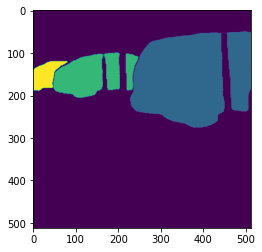

In [128]:
plt.imshow(instance_map.numpy())
plt.show()

In [129]:
xm = torch.linspace(0, 2, 2048).view(1, 1, -1).expand(1, 1024, 2048)
ym = torch.linspace(0, 1, 1024).view(1, -1, 1).expand(1, 1024, 2048)
xym = torch.cat((xm, ym), 0)

prediction = output[0]
n_sigma = 1

height, width = prediction.size(1), prediction.size(2)
xym_s = xym[:, 0:height, 0:width]
        
spatial_emb = torch.tanh(prediction[0:2]) + xym_s.cuda()  # 2 x h x w
sigma = prediction[2:2+n_sigma]  # n_sigma x h x w

# sigmoid is applied to seed_map
# as the regression loss is used for training, b.g pixels become zero
# it is similar to semantic mask
seed_map = torch.sigmoid(prediction[2+n_sigma:2+n_sigma + 1])  # 1 x h x w
       
instance_map = torch.zeros(height, width).byte()
instances = []

count = 1
mask = seed_map > 0.5

print(mask.shape)
print(mask.sum())

torch.Size([1, 512, 512])
tensor(65788, device='cuda:0')


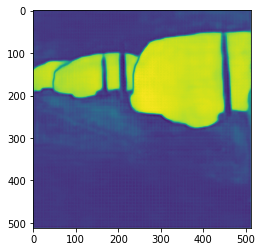

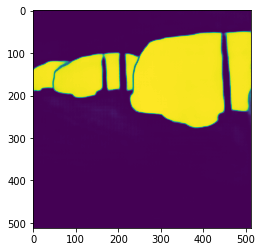

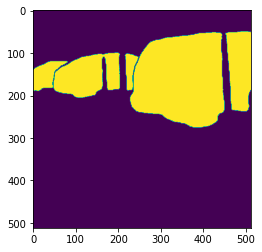

In [130]:
plt.imshow(prediction[2+n_sigma:2+n_sigma + 1][0].cpu().detach().numpy())  # seed map
plt.show()
plt.imshow(seed_map[0].cpu().detach().numpy())  # sigmoid(seed map)
plt.show()
plt.imshow(mask[0].cpu().detach().numpy())  # sigmoid(seed map) > 0.5
plt.show()

In [131]:
spatial_emb_masked = spatial_emb[mask.expand_as(spatial_emb)].view(2, -1)
sigma_masked = sigma[mask.expand_as(sigma)].view(n_sigma, -1)
seed_map_masked = seed_map[mask].view(1, -1)

unclustered = torch.ones(mask.sum()).byte().cuda()
instance_map_masked = torch.zeros(mask.sum()).byte().cuda()

print(spatial_emb_masked.shape)
print(sigma_masked.shape)
print(seed_map_masked.shape)
print(unclustered.shape)
print(instance_map_masked.shape)

torch.Size([2, 65788])
torch.Size([1, 65788])
torch.Size([1, 65788])
torch.Size([65788])
torch.Size([65788])


In [132]:
threshold = 0.9

height, width = prediction.size(1), prediction.size(2)
xym_s = xym[:, 0:height, 0:width]
        
spatial_emb = torch.tanh(prediction[0:2]) + xym_s.cuda()  # 2 x h x w
sigma = prediction[2:2+n_sigma]  # n_sigma x h x w
seed_map = torch.sigmoid(prediction[2+n_sigma:2+n_sigma + 1])  # 1 x h x w
       
instance_map = torch.zeros(height, width).byte()
instances = []

count = 1
mask = seed_map > 0.5

centers = []
dists = []

if mask.sum() > 128:
    
    # at inference time, we select a pixel embedding with a high seed score
    # embedding with the highest seed score is close to instance's center
    spatial_emb_masked = spatial_emb[mask.expand_as(spatial_emb)].view(2, -1)
    sigma_masked = sigma[mask.expand_as(sigma)].view(n_sigma, -1)
    seed_map_masked = seed_map[mask].view(1, -1)
    
    unclustered = torch.ones(mask.sum()).byte().cuda()
    instance_map_masked = torch.zeros(mask.sum()).byte().cuda()

    while(unclustered.sum() > 128):

        seed = (seed_map_masked * unclustered.float()).argmax().item()
        seed_score = (seed_map_masked * unclustered.float()).max().item()
        if seed_score < threshold:
            break
        
        # define instance center (embedding with the highest seed score)
        center = spatial_emb_masked[:, seed:seed+1]
        unclustered[seed] = 0
        # accompanying sigma (instance specific margin)
        s = torch.exp(sigma_masked[:, seed:seed+1]*10)
        dist = torch.exp(-1*torch.sum(torch.pow(spatial_emb_masked -
                                                center, 2)*s, 0, keepdim=True))
        dists.append(dist)
        
        # e.q (11)
        proposal = (dist > 0.5).squeeze()

        if proposal.sum() > 128:
            if unclustered[proposal].sum().float()/proposal.sum().float() > 0.5:
                instance_map_masked[proposal.squeeze()] = count
                instance_mask = torch.zeros(height, width).byte()
                instance_mask[mask.squeeze().cpu()] = proposal.cpu().byte()
                instances.append(
                    {'mask': instance_mask.squeeze()*255, 'score': seed_score})
                count += 1

        unclustered[proposal] = 0

    instance_map[mask.squeeze().cpu()] = instance_map_masked.cpu()

In [133]:
instances

[{'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
  'score': 0.9942671656608582},
 {'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
  'score': 0.9889660477638245},
 {'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
  'score': 0.9862154722213745}]

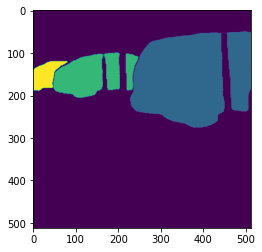

In [134]:
plt.imshow(instance_map.cpu().detach().numpy())
plt.show()

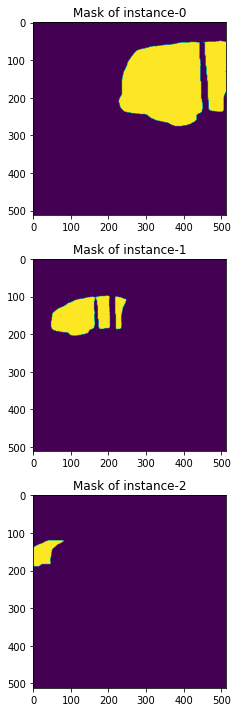

In [138]:
rows = 3
cols = 1
axes = []
fig = plt.figure(figsize=(20, 10))

for a in range(rows * cols):
    b = instances[a]['mask'].cpu().detach()
    axes.append(fig.add_subplot(rows, cols, a+1) )
    subplot_title = ("Mask of instance-" + str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
    
fig.tight_layout()    
plt.show()